In [936]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.linear_model import Lasso
from IPython.display import display, HTML

%matplotlib inline

## Convert Categorical Data to Dummy Variables

In [937]:
def categoricalColumnNames(columnName, attributeList):
    return ['{}_{}'.format(columnName, attribute)
            for attribute in attributeList]


# def categoricalVectors(attributeList):
#     return [np.zeros(len(attrValues) - 1) for attr in attributeList]
    

# Convert nominal variable x to its dummy vector variable representation
def _convertNominalVariable(dataFrame, columnName):
    attrValues = dataFrame[columnName].unique()
    newColumns = categoricalColumnNames(columnName, attrValues)
    encodingList = [np.zeros(len(attrValues) - 1) for attr in attrValues]
    
    for newColumn, value in zip(newColumns, attrValues):
        dataFrame[newColumn] = pd.Series(dtype=np.int64)
        dataFrame.loc[dataFrame[columnName] == value, newColumn] = int(1)
        dataFrame.loc[dataFrame[columnName] != value, newColumn] = int(0)
    
    for i in range(1, len(attrValues)):
        encodedAttr = encodingList[i]
        encodedAttr[i - 1] = int(1)
    
    return dataFrame


def convertNominalVariables(dataFrame, columnList):
    newDf = pd.DataFrame(dataFrame)
    
    for attribute in columnList:
        newDf = _convertNominalVariable(newDf, attribute)
    return newDf
        
    
# Convert ordinal variable x to its dummy vector variable representation
def _convertOrdinalVariable(dataFrame, columnName, orderedAttributes):
    oneHotDf = _convertNominalVariable(dataFrame, columnName)
    newAttrNames = categoricalColumnNames(columnName, orderedAttributes)
    attrIndices = {}
    
    for i, attr in enumerate(orderedAttributes):
        attrIndices[attr] = int(i)
    
    for i, newOldAttr in enumerate(zip(orderedAttributes, newAttrNames)):
        oldAttr, newAttr = newOldAttr
        
        for attrName in newAttrNames[:i]:
            oneHotDf.loc[oneHotDf[columnName] == oldAttr, attrName] = int(1)
    return oneHotDf

## Evaluation Measures

In [938]:
def checkR2(x, y):
    slope, intercept, r2, p_val, std_err = stats.linregress(x, y)
    print('slope={}, intercept={}, R2={}'.format(slope, intercept, r2 ** 2))
    
# Returns 2 measures of R2: (1 - SSE / SST, SSR / SST)
def computeR2(x, y, beta, insertOnes=True):
    yMean = np.mean(y)
#     print('Y:', y)
#     print('Y mean:', yMean)
    yPredicted = np.array([linRegEstimate(xVal, beta, insertOnes) for xVal in x])
#     print('Y predicted:', yPredicted)
    ssTotal = np.sum(np.square(y - yMean))
    ssRegression = np.sum(np.square(yPredicted - yMean))
    ssError = np.sum(np.square(y - yPredicted))
#     print('SST={}, SSR={}, SSE={}'.format(ssTotal, ssRegression, ssError))
    
    return 1 - ssError / ssRegression

"""
Computes the accuracy, precision, recall, and F-score of a dataframe
Params:
    testDf: pandas.DataFrame
    predictedDf: pandas.DataFrame
Returns: (accuracy, precision, recall, F-score)
"""
def scoreLogClassification(testVals, predictedVals):
    tp = tn = fp = fn = 0
    
    for testVal, predictedVal in zip(testVals, predictedVals):
        if testVal == predictedVal:
            if testVal == 1:
                tp += 1
            else:
                tn += 1
        else:
            if testVal == 1:
                fn += 1
            else:
                fp += 1
    
    accuracy = (tp + tn) / len(testVals)
    precision = tp / (tp + fp) if tp + fp > 0 else float('NaN')
    recall = tp / (tp + fn) if tp + fn > 0 else float('NaN')
    fScore = 2 * precision * recall / (precision + recall) if precision + recall > 0 else float('NaN')
    
    return accuracy, precision, recall, fScore

## Linear Regression Functions

In [939]:
"""
inputVals: vector in form of [x1, x2, ..., xn]
beta: vector of beta coefficients in form [b0, b1, b2, ..., bn]
"""
def linRegEstimate(inputVals, beta, insertOnes=True):
    if insertOnes:
        inputMatrix = np.insert(inputVals, 0, 1)
    else:
        inputMatrix = np.array(inputVals)
    return np.sum(inputMatrix * beta)


"""
matrix: matrix of points in form [[x1, x2, ..., xn], ...]
returns: (beta, pearsonCorrelation) tuple
"""
def computeLinRegBeta(x, y):
    # Reshape 1-D arrays to column format
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
        
    m = len(x)
    newX = np.insert(x, 0, np.ones(m), axis=1)
    
    # Reshape y from vector to 1-D matrix rows
    newY = y.reshape(-1, 1)
#     print('Y:', newY)
    xTxInverse = np.linalg.inv(newX.T.dot(newX))
    beta = xTxInverse.dot(newX.T).dot(newY)
#     print('x.T:', x)
#     print('y.T[0]:', y)
    return beta.T[0], np.corrcoef(x.T, newY.T[0])[0, 1] ** 2

# Logistic Regression

In [940]:
"""
Returns a function that takes a vector X (same dimensions as parameter x),
    and predicts class 0 or 1 based on X.
    Return type: (function, R^2 correlation)
Params:
    x: input vector
    y: 1-D class vector of 0s and 1s
"""
def getLogisticRegFunc(x, y):
    beta, correlation = computeLinRegBeta(x, y)
    def logRegEstimate(xVector):
        estimate = 1 / (1 + np.exp(linRegEstimate(xVector, beta)))
        return estimate, int(round(estimate))
    return logRegEstimate, correlation

# Utilities

In [941]:
def plotSingleVarRegressions(xCols, yCol):
    yColValues = yCol.as_matrix()
    
    for col in xCols:
        colValues = col.as_matrix()
        colBetas, colCorrelation = computeLinRegBeta(colValues, yColValues)

        xMin = colValues.min()
        xMax = colValues.max()
        xRange = np.arange(xMin * .85, xMax * 1.15, (xMax - xMin) / 10)
        predictedLine = [linRegEstimate([x], colBetas) for x in xRange]

        fig = plt.figure()
        graph = fig.add_subplot(111)
        fig.suptitle('Predicting {} levels from {} levels'.format(yCol.name, col.name),
                    y=1.08, fontsize=14, fontweight='bold')
        graph.set_title('Beta: {}, R2: {}'.format(colBetas, colCorrelation))
        graph.title.set_position([0.5, 1.05])
        graph.set_ylabel(yCol.name)
        graph.set_xlabel(col.name)
        graph.plot(colValues, yColValues, 'bo', xRange, predictedLine, 'r-', linewidth=3.0)
        
def getDfNamesByType(df):
    columnNamesByType = df.columns.to_series().groupby(df.dtypes).groups
    return {key.name: val for key, val in columnNamesByType.items()}

def displayBetaTable(attrNames, beta):
    betaAttrMap = {attr: beta for attr, beta in zip(['Intercept'] + attrNames, beta)}
    display(pd.DataFrame(betaAttrMap, index=np.arange(1)))

# Gradient Descent

In [942]:
def gradientDescent(data, learningRate):
    gradient = np.gradient(np.array(data))

# Air Quality UCI Set
### Source: UCI ML Repository https://archive.ics.uci.edu/ml/datasets/Air+Quality

In [943]:
convertEuropeanFloats = lambda val: float(val.replace(',', '.'))
airQualityDf = pd.read_csv('data/AirQualityUCI.csv', sep=';',
                           converters={
        'CO(GT)': convertEuropeanFloats,
        'C6H6(GT)': convertEuropeanFloats,
        'T': convertEuropeanFloats,
        'RH': convertEuropeanFloats
    })
airQualityDf.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

columnNamesByType = getDfNamesByType(airQualityDf)
airQualityXColNames = [col for col in list(columnNamesByType['float64']) + list(columnNamesByType['int64'])
                      if col != 'CO(GT)']
airQualityDf.drop(airQualityDf[airQualityDf['CO(GT)'] == -200.0].index, inplace=True)

for xCol in airQualityXColNames:
    # -200 means missing value
    airQualityDf.drop(airQualityDf[airQualityDf[xCol] == -200.0].index, inplace=True)

In [944]:
airQualityY = airQualityDf['CO(GT)']
airQualityXCols = [airQualityDf[attr]
                   for attr in airQualityXColNames]

COValues = airQualityY.as_matrix()
# plotSingleVarRegressions(airQualityXCols, airQualityY)

## Predicting CO Concentration from C6H6 (Benzene) Concentration
### Benzene is a highly flammable core component of gasoline

,C6H6(GT),Intercept
0,0.184812,0.362939


C6H6(GT) to predict CO(GT) R^2: 0.946066616914


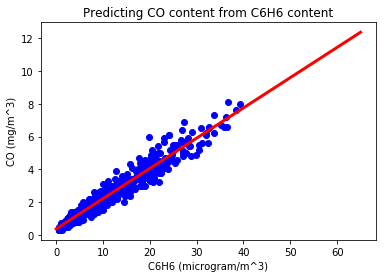

In [945]:
c6h6GTValues = airQualityDf['C6H6(GT)'].as_matrix()
c6h6VsCOBetas, c6h6VsCOCorrelation = computeLinRegBeta(c6h6GTValues, COValues)
displayBetaTable(airQualityXColNames, c6h6VsCOBetas)
print('C6H6(GT) to predict CO(GT) R^2:', c6h6VsCOCorrelation)
# print('C6H6(GT) to CO(GT) beta:', c6h6VsCOBetas)

xRange = np.arange(0, 70, 5)
predictedLine = [linRegEstimate([c6h6], c6h6VsCOBetas) for c6h6 in xRange]

plt.plot(c6h6GTValues, COValues, 'bo', xRange, predictedLine, 'r-', linewidth=3.0)
plt.title('Predicting CO content from C6H6 content')
plt.xlabel('C6H6 (microgram/m^3)')
plt.ylabel('CO (mg/m^3)')

# Bivariate Case
## Predicting CO Levels from Benzene and Titania (PT08.S2) Levels

,C6H6(GT),PT08.S2(NMHC),CO(GT)
0,11.9,1046,2.6
1,9.4,955,2.0
2,9.0,939,2.2
3,9.2,948,2.2
4,6.5,836,1.6


,C6H6(GT),Intercept,PT08.S2(NMHC)
0,0.181598,0.309765,0.000091


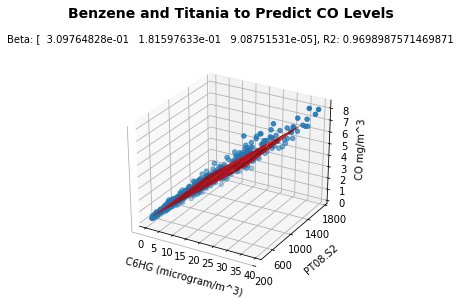

In [946]:
benzenePT08Df = airQualityDf[['C6H6(GT)', 'PT08.S2(NMHC)']]
benzenePT08 = benzenePT08Df.as_matrix()
benzenePT08Betas, benzenePT08Correlation = computeLinRegBeta(benzenePT08, COValues)

benzeneMin = benzenePT08[:, 0].min()
benzeneMax = benzenePT08[:, 0].max()
PT08Min = benzenePT08[:, 1].min()
PT08Max = benzenePT08[:, 1].max()

benzeneDomain = np.arange(benzeneMin, benzeneMax, (benzeneMax - benzeneMin) / 10)
PT08Domain = np.arange(PT08Min, PT08Max, (PT08Max - PT08Min) / 10)
benzenePT08Domains = np.array([benzeneDomain, PT08Domain]).T
benzenePT08PredictedCO = [linRegEstimate(xy, benzenePT08Betas)
                          for xy in benzenePT08Domains]

display(airQualityDf[['C6H6(GT)', 'PT08.S2(NMHC)', 'CO(GT)']].head())
displayBetaTable(['C6H6(GT)', 'PT08.S2(NMHC)'], benzenePT08Betas)

fig = plt.figure()
fig.suptitle('Benzene and Titania to Predict CO Levels',
             y=1.05, fontsize=14, fontweight='bold')

benzPT08Plot = fig.add_subplot(111, projection='3d')
benzPT08Plot.scatter(benzenePT08[:, 0], benzenePT08[:, 1], COValues)
gridBenzPTO8, gridPT08Domain = np.meshgrid(benzeneDomain, PT08Domain)
benzPT08Plot.plot_surface(gridBenzPTO8, gridPT08Domain, benzenePT08PredictedCO, color='r')
benzPT08Plot.set_title('Beta: {}, R2: {}'.format(benzenePT08Betas, benzenePT08Correlation),
                      y=1.05, fontsize=10)
benzPT08Plot.set_xlabel('C6HG (microgram/m^3)', labelpad=10.5)
benzPT08Plot.set_ylabel('PT08.S2', labelpad=10.5)
benzPT08Plot.set_zlabel('CO mg/m^3')

benzPT08Plot.set_yticks(np.arange(200, 2000, 400))
benzPT08Plot.dist = 12

plt.tight_layout()

# Multivariate Linear Regression

In [947]:
airQualityMultiCols = list(set(airQualityXColNames) - set(['T', 'RH',' PT08.S4(NOx)',
                                                           'PT08.S4(NO2)', 'NMHC(GT)',
                                                          'PT08.S3(NOx)', 'PT08.S5(O3)']))
display(airQualityDf[airQualityMultiCols].head())

multiAirQualityXVals = airQualityDf[airQualityMultiCols].as_matrix()

multiAirQualityBeta, multiAirQualityR2 = computeLinRegBeta(
    multiAirQualityXVals, COValues)
computedAirQualityR2 = computeR2(multiAirQualityXVals,
                                COValues, multiAirQualityBeta)
betaAttributeMap = {attr: beta for attr, beta in zip(['Intercept'] + airQualityMultiCols, multiAirQualityBeta)}

# print('Betas for all X Cols:', multiAirQualityBeta)
print('R2 for all X cols:', multiAirQualityR2)
display(pd.DataFrame(betaAttributeMap, index=np.arange(1)))

,PT08.S2(NMHC),C6H6(GT),PT08.S1(CO),NOx(GT),NO2(GT)
0,1046,11.9,1360,166,113
1,955,9.4,1292,103,92
2,939,9.0,1402,131,114
3,948,9.2,1376,172,122
4,836,6.5,1272,131,116


R2 for all X cols: 0.969898757147


,C6H6(GT),Intercept,NO2(GT),NOx(GT),PT08.S1(CO),PT08.S2(NMHC)
0,0.163175,0.500713,0.004138,0.005148,0.000516,-0.001741


# Multivariate Linear Regression with Categorical Attributes
## HR Employee Dataset
### Source: Kaggle https://www.kaggle.com/ludobenistant/hr-analytics

In [948]:
hrDf = pd.read_csv('data/HR_comma_sep.csv', sep=',')
# hrDf.loc[hrDf['last_evaluation'], 'last_evaluation'] = 
hrDf['last_evaluation'] *= 100
hrDf['satisfaction_level'] *= 100
display(hrDf.head())


# convertedHrDf = _convertOrdinalVariable(hrDf, 'salary', ['low', 'medium', 'high'])
convertedHrDf = convertNominalVariables(hrDf, ['sales', 'salary'])
# print(convertedHrDf['sales'].unique())

hrYColName = 'satisfaction_level'
hrCategoricalCols = ['sales', 'salary']
hrXColNames = ['number_project', 'last_evaluation', 'time_spend_company',
              'promotion_last_5years', 'satisfaction_level']
for col in hrCategoricalCols:
    hrXColNames.extend(categoricalColumnNames(col, convertedHrDf[col].unique()))
print(hrXColNames)

# display(convertedHrDf[hrXColNames].head())
hrXMatrix = convertedHrDf[hrXColNames].as_matrix()
hrYMatrix = convertedHrDf[hrYColName].as_matrix()
# print(hrXMatrix.shape)
# print(hrYMatrix.reshape(-1, 1).shape)

beta = np.linalg.lstsq(hrXMatrix, hrYMatrix)[0] 
# print(computeR2(hrXMatrix, hrYMatrix, beta))

hrBeta, hrR2 = computeLinRegBeta(
    hrXMatrix, hrYMatrix)
print('Beta:', hrBeta)
print('R^2:', hrR2)
displayBetaTable(hrXColNames, hrBeta)

# plotSingleVarRegressions([convertedHrDf[col] for col in hrXColNames], convertedHrDf[hrYColName])

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,38.0,53.0,2,157,3,0,1,0,sales,low
1,80.0,86.0,5,262,6,0,1,0,sales,medium
2,11.0,88.0,7,272,4,0,1,0,sales,medium
3,72.0,87.0,5,223,5,0,1,0,sales,low
4,37.0,52.0,2,159,3,0,1,0,sales,low


['number_project', 'last_evaluation', 'time_spend_company', 'promotion_last_5years', 'satisfaction_level', 'sales_sales', 'sales_accounting', 'sales_hr', 'sales_technical', 'sales_support', 'sales_management', 'sales_IT', 'sales_product_mng', 'sales_marketing', 'sales_RandD', 'salary_low', 'salary_medium', 'salary_high']
Beta: [  5.15984009e+02  -4.65169826e+00   9.22118751e-02   7.23443971e-01
  -1.57187201e+01   9.34591003e-01  -2.13441467e+02  -1.09616531e+02
  -3.56766098e+02  -3.16244736e+02  -2.31082825e+02  -3.64820404e+02
  -3.76059799e+02  -2.07574020e+02  -3.30350769e+02  -2.37953781e+02
  -1.06404541e+02  -4.21852417e+01   3.20409160e+01]
R^2: 0.122033257399


,Intercept,last_evaluation,number_project,promotion_last_5years,salary_high,salary_low,salary_medium,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,satisfaction_level,time_spend_company
0,515.984009,0.092212,-4.651698,-15.71872,32.040916,-106.404541,-42.185242,-376.059799,-237.953781,-109.616531,-356.766098,-364.820404,-330.350769,-207.57402,-213.441467,-231.082825,-316.244736,0.934591,0.723444


# Multivariate Linear Regression with Categorical Attributes
### Source: UCI ML Repository https://archive.ics.uci.edu/ml/datasets/Automobile

## Data Cleaning

In [949]:
carDf = pd.read_csv('data/imports-85.csv', sep=',')
carYColName = 'Price'
categoricalCarCols = ['Make', 'FuelType', 'DriveWheels']
carXColNames = ['CityMPG', 'HighwayMPG'] + categoricalCarCols


carDf.drop(carDf[carDf['Horsepower'] == '?'].index, inplace=True)
carDf.drop(carDf[carDf['Price'] == '?'].index, inplace=True)
carDf['Horsepower'] = pd.to_numeric(carDf['Horsepower'])
carDf['Price'] = pd.to_numeric(carDf['Price'])

carColNamesByType = getDfNamesByType(carDf)
makeXCols = categoricalColumnNames('Make', carDf['Make'].unique())
numberCylindersXCols = categoricalColumnNames('NumberCylinders',
                                              carDf['NumberCylinders'].unique())
# carXColNames = ['CityMPG', 'HighwayMPG'] + makeXCols
# carXColNames = ['Price'] + makeXCols
display(carDf[carXColNames + [carYColName]].head())

nominalCarDf = convertNominalVariables(carDf, ['Make', 'FuelType', 'DriveWheels'])
convertedCarDf = _convertOrdinalVariable(nominalCarDf, 'NumberCylinders',
                                         ['two', 'three', 'four', 'five', 'six', 'eight', 'twelve'])
convertedCarXColNames = ['CityMPG', 'HighwayMPG']
for col in categoricalCarCols:
    convertedCarXColNames.extend(categoricalColumnNames(col, convertedCarDf[col].unique()))

for col in makeXCols + numberCylindersXCols:
    convertedCarDf[col] = convertedCarDf[col].astype('int')

,CityMPG,HighwayMPG,Make,FuelType,DriveWheels,Price
0,21,27,alfa-romero,gas,rwd,13495
1,21,27,alfa-romero,gas,rwd,16500
2,19,26,alfa-romero,gas,rwd,16500
3,24,30,audi,gas,fwd,13950
4,18,22,audi,gas,4wd,17450


## Predicting Price from Make, Number of Cylinders, City MPG, and Highway MPG

In [950]:
carXColsDf = convertedCarDf[convertedCarXColNames]
carXColMatrix = carXColsDf.as_matrix()
carYColMatrix = convertedCarDf[carYColName].as_matrix()

carBeta, carCorrelation = computeLinRegBeta(carXColMatrix, carYColMatrix)

print('Car price prediction')
print('Beta:', carBeta)
displayBetaTable(carXColNames, carBeta)
print('R^2:', carCorrelation)

Car price prediction
Beta: [ -3.84878182e+19   6.81275291e+04  -5.00900769e+04  -3.71765409e+19
  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19
  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19
  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19
  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19
  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19  -3.71765409e+19
   7.56643591e+19   7.56643591e+19  -3.55513344e+05  -4.31575031e+05
  -3.65030477e+05]


,CityMPG,DriveWheels,FuelType,HighwayMPG,Intercept,Make
0,68127.529122,-3.717654e+19,-3.717654e+19,-50090.076948,-3.848782e+19,-3.717654e+19


R^2: 0.946295628773


# Predicting Malignancy of Breast Cancer Cases
## First: Convert Malignancy Class into 0 = Benign and 1 = Malignant

In [951]:
breastCancerDf = pd.read_csv('data/breast-cancer-wisconsin.csv')
breastCancerDf.loc[breastCancerDf['Class'] == 2, 'Class'] = 0
breastCancerDf.loc[breastCancerDf['Class'] == 4, 'Class'] = 1

print('% malignant', len(breastCancerDf['Class'].loc[breastCancerDf['Class'] == 1]) / len(breastCancerDf['Class']))

# Split into test and training sets
np.random.seed(524)
trainProportion = 0.8
trainMask = np.random.rand(len(breastCancerDf)) < trainProportion
cancerTrainingDf = breastCancerDf[trainMask]
cancerTestDf = breastCancerDf[~trainMask].reset_index()
print('Total # cancer samples: {}, training samples: {}, test samples: {}'.format(
    len(breastCancerDf), len(cancerTrainingDf), len(cancerTestDf)))

possiblePredictors = [col for col in breastCancerDf.columns
                     if col != 'Class' and col != 'ID']
classVals = breastCancerDf['Class']

cancerColsByType = getDfNamesByType(breastCancerDf)
breastCancerXCols = [breastCancerDf[predictor] for predictor in cancerColsByType['int64']
                    if predictor != 'ID' and predictor != 'Class']

# plotSingleVarRegressions(breastCancerXCols, classVals)

% malignant 0.3447782546494993
Total # cancer samples: 699, training samples: 571, test samples: 128


In [952]:
predictor = ['CellShapeUniformity', 'CellSizeUniformity']
trainingMatrix = cancerTrainingDf[predictor].as_matrix()
testMatrix = cancerTestDf[predictor].as_matrix()
# print('Training matrix:', trainingMatrix)
malignancyPredictor, cancerR2 = getLogisticRegFunc(trainingMatrix,
                                         cancerTrainingDf['Class'].as_matrix())
print('Cancer malignancy R^2:', cancerR2)
malignancyPredictions = [malignancyPredictor([sample])
                                                for sample in testMatrix]
maligPredictDf = pd.DataFrame({'Class': [predictedClass for estimate, predictedClass
                                               in malignancyPredictions],
                              'Estimate': [estimate for estimate, predictedClass
                                          in malignancyPredictions]})
# print(maligPredictDf['Class'])
# print(malignancyPredictions)
# TODO: Plot actual returned regression estimate
# print(cancerTestDf['Class'].name)
# maligPredictDf['Estimate'].plot()
print('Cancer malignancy model scores:',
      scoreLogClassification(cancerTestDf['Class'], maligPredictDf['Class']))

Cancer malignancy R^2: 0.834898008399
Cancer malignancy model scores: (0.6640625, nan, 0.0, nan)
